# 동시성 소켓 프로그래밍
## select 모듈을 이용한 소켓 프로그래밍

입출력을 동기적으로 처리하면 프로그램 실행 도중에 입출력의 발생을 기다려야 하므로 비효율적이다.  
따라서 비동기적으로 입출력을 처리하면 효율적 프로그래밍이 가능하다.  
+ 호출된 입출력 함수는 반환되고 다른 작업을 수행하다가 나중에 입출력을 처리하는 방법 사용
+ 다른 작업을 수행하는 중에 비동기 입출력의 발생을 알 수 있는 방법 필요
  + select 모듈의 select() 함수
  + 읽기, 쓰기, 오류 이벤트가 발생한 소켓을 소켓 목록에 저장

### select 모듈을 이용한 서버 프로그램

select 모듈을 이용하여 채팅 서버를 구현한다.  

+ 이벤트 발생 소켓 조사 방법  
```
r_sock, w_sock, e_sock = select.select(s_list1, s_list2, s_list3, timeout)
```
  > r_sock : 읽기 이벤트 발생 소켓 목록  
  > w_sock : 쓰기 이벤트 발생 소켓 목록  
  > e_sock : 오류 이벤트 발생 소켓 목록  

  > s_list1 : 읽기 이벤트 조사 소켓 목록  
  > s_list2 : 쓰기 이벤트 조사 소켓 목록  
  > s_list3 : 오류 이벤트 조사 소켓 목록  
  
<select() 함수의 동작>  
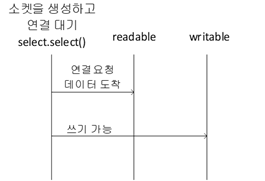

<select() 함수를 이용한 서버 프로그램의 동작 순서>  
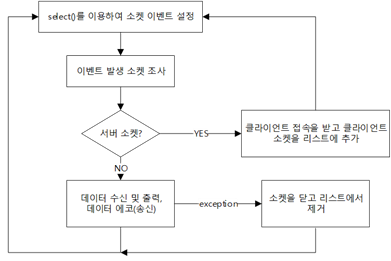

In [ ]:
#select_server.py
#select를 이용한 TCP 멀티 에코 서버

import socket, select

if __name__=="__main__":
    #읽기 가능 소켓 목록
    socks = [] 
    BUFFER = 1024
    port = 2500
    
    s_sock = socket.socket() #TCP socket
    s_sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    s_sock.bind(('', port))
    s_sock.listen(5)

    #서버 소켓을 소켓 목록에 추가
    socks.append(s_sock) 
    print(str(port) + "에서 접속 대기 중 ")

In [ ]:
    #소켓에서 발생한 이벤트 처리
    while True:
        #이벤트 발생 소켓 설정(읽기 이벤트만 조사)
        r_sock, w_sock, e_sock = select.select(socks, [], [])

        #
        # 필요하면 이 부분에서 다른 코드를 처리할 수 있다
        #

        #읽기 소켓 리스트의 소켓 조사
        for s in r_sock: 
            #읽기 이벤트 발생 소켓이 서버 소켓이면 연결 요청
            if s == s_sock:
                c_sock, addr = s_sock.accept() #새로운 클라이언트 연결
                socks.append(c_sock) #연결된 소켓을 소켓 리스트에 추가
                print(" Client (%s, %s) connectd" %addr)
                
            #읽기 이벤트 발생 소켓이 클라이언트면 데이터 수신
            else:
                #연결되지 않았으면 예외가 발생할 수 있으므로 try로 처리
                try: 
                    #데이터를 수신하여 출력하고 다시 송신(에코)
                    data = s.recv(BUFFER) #데이터 수신
                    print("Received: ", data.decode())
                    if data:
                        s.send(data) #수신 데이터를 다시 전송
                        
                #연결되지 않아 수신 데이터가 없음
                except: 
                    print("Client (%s, %s) is offline" %addr)
                    #소켓을 닫는다
                    s.close()
                    
                    #연결 종료된 소켓을 목록에서 제거
                    socks.remove(s) 
                    continue
                
    s_sock.close()

**[실행 방법]**  
서버 프로그램을 먼저 실행하고, 클라이언트 프로그램(TCP_client.py)을 두 번이상 실행해 보자. 서버는 각 클라이언트에서 보내온 메시지를 출력하고 다시 되돌려 보낸다. 서버는 두 개의 클라이언트 접속을 받아 에코 기능을 모두 수행한 것을 볼 수 있다.

### select 모듈을 이용한 클라이언트 프로그램

select 모듈을 이용하여 클라이언트를 구현한다.
* 블로킹 모드에서 데이터 수신을 대기하는 것이 아니라 수신 데이터가 없으면 송신 등 다른 일을 처리할 수 있다
* select 함수를 호출할 때 timeout=0으로 설정하면 넌블로킹 모드로 동작

In [ ]:
#select_client.py
# select 모듈을 이용한 TCP 클라이언트 프로그램

from socket import *
from select import *

#접속 소켓 목록
socks = []
sock = socket()
sock.setsockopt(SOL_SOCKET, SO_REUSEADDR, 1)

#생성된 소켓을 목록에 추가
socks.append(sock) 
sock.connect(('localhost', 2500)) #서버 연결

In [ ]:
#이벤트 발생 소켓 조사
while True:
    #읽기 이벤트만 조사. 넌블록킹 모드
    r_sock, w_sock, e_sock = select(socks,[],[], 0) 
    if r_sock: #읽기 이벤트 발생?
        for s in r_sock:
            if s == sock: #자신에게 온 데이터인가?
                msg = sock.recv(1024).decode()
                print("수신 메시지:", msg)
    smsg = input("전송 메시지: ")
    sock.sendall(smsg.encode())

**[실행 방법]**  
앞에서 작성한 서버 프로그램(select_server.py)을 먼저 실행하고 클라이언트 프로그램(select_client.py)을 실행해 보자.

**[퀴즈]**  
위 프로그램에서 select()를 호출한 다음에 time.sleep(5)를 추가해보자. 프로그램의 실행이 어떻게 달라지는가? 그 이유는 무엇인가?

### select 모듈을 이용한 GUI 소켓 클라이언트 프로그래밍

tkinter의 mainloop() 함수가 처리하지 못하는 소켓 이벤트를 select() 함수를 이용하여 GUI에서 처리하는 프로그램을 알아보자  
    
+ [ON]/[OFF] 버튼을 클릭할 때마다 색상이 변하고 메시지(ON 또는 OFF)를 에코 서버로 전송한다
+ 에코 서버 메시지를 수신하여 라벨로 표시한다

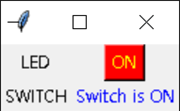
+ mainloop()가 실행되면 메시지 도착 이벤트는 더 이상 처리하지 못함
+ tkinter 모듈의 after() 함수를 이용하여 소켓 이벤트를 주기적으로 처리한다
  + after(delay_time, method)
    + delay_time 경과 후 method를 주기적으로 실행  

**프로그램 구성**  

```python
handle()  
# 주기적으로 메시지를 수신하여 라벨로 표시하는 함수
# after(delay_time, handle)

button_command()  
# 버튼 클릭 콜백 함수

main 함수  
# 소켓을 만들고(전역 변수) 화면을 구성한다
# handle() 호출
```

In [ ]:
#select_GUI_client.py
#GUI TCP 클라이언트 프로그램
#버튼 클릭으로 ON/OFF 제어

from socket import *
from tkinter import *
from select import *

#데이터를 수신하고 처리하는 함수
def handle():
    global root, sock, switch_state_label
    
    #읽기 조사 소켓 설정
    r_sock, w_sock, e_sock = select([sock], [], [], 0)
    
    #읽기 이벤트가 발생한 소켓에서 데이터를 읽고 메시지를 처리한다
    if r_sock:
        msg = sock.recv(1024).decode()
        print(msg)
        #토글 동작
        if msg.upper() == 'OFF':
            switch_state_label.configure(text='Switch is OFF')
        else:
            switch_state_label.configure(text='Switch is ON')
            
    #연속적인 동작을 위해 200ms 후에 다시 handle 함수 호출
    root.after(200, handle)

In [ ]:
#버튼 클릭 콜백 함수
def button_command():
    global sock, btn_text, btn_color
    
    if btn_text == 'ON':
        btn_text = 'OFF'
        btn_color = 'blue'
    
    else:
        btn_text = 'ON'
        btn_color = 'red'
    
    LED_button.configure(text=btn_text, bg=btn_color)#버튼 표시 수정
    sock.send(btn_text.encode()) #LED 상태 전송
    

In [ ]:
#소켓을 생성하고 연결
sock = socket() #기본으로 TCP 소켓 생성
sock.connect(('localhost', 2500))

#루트 윈도우
root = Tk()
btn_color = 'red'
btn_text = 'ON'

#라벨과 버튼 생성
LED_label = Label(text="LED")
Switch_label = Label(text="SWITCH")
switch_state_label = Label(text="Switch is OFF",fg='blue')
LED_button = Button(text=btn_text, fg='yellow',
                    bg=btn_color, command=button_command)

#라벨과 버튼 배치
LED_label.grid(row=0, column=0)
LED_button.grid(row=0, column=1)
Switch_label.grid(row=1, column=0)
switch_state_label.grid(row=1, column=1, sticky=E)

#데이터를 읽고 처리한다
handle() # mainloop() 이전에 실행해야 한다
root.mainloop() #윈도우 루프 실행

**[실행 방법]**  
서버 프로그램(select_server.py)을 먼저 실행하고 select_GUI_client.py를 실행한다. LED 버튼을 클릭하면 ON/OFF가 교대로 표시된다. 클라이언트에서 LED 상태를 서버로 보내면 서버는 ON 또는 OFF 메시지를 그대로 되돌려준다. 클라이언트에서는 서버로부터 받은 메시지에 따라 “Switch is ON” 또는 “Switch is OFF”를 라벨로 표시한다.

### select와 queue 모듈을 이용한 소켓 프로그래밍



**생략**

## socketserver 모듈을 이용한 서버 프로그래밍
socketserver 모듈은 비동기 서버 프로그램을 작성하기 위한 모듈이며, socketserver 모듈 프로그램을 위해서 서버 객체와 핸들러 클래스 필요하다  

+ TCP 또는 UDP 서버 가능
  + TCP 서버 객체 생성: socketserver.TCPServer 클래스 이용
  + UDP 서버 객체 생성: socketserver.UDPServer 클래스 이용  
  

+ 핸들러 클래스
  + 클라이언트의 데이터를 읽고 필요한 작업을 수행
  + 서버 객체를 생성할 때 지정
  + socketserver 모듈의 BaseRequestHandler 클래스 상속받음
  + 재정의(redefinable) 가능 메서드
    + setup(): 연결되면 실행되는 메서드
    + handle(): 데이터가 수신되면 실행되는 메서드  
      데이터 송수신을 위해 필요한 소켓과 상대방 주소는 BaseRequestHandler 클래스의 request와 client_address 인스턴스 변수로 정의되어 있다
    + finish(): 연결이 해제되면 실행되는 메서드
    

<socketserver 모듈의 동작>

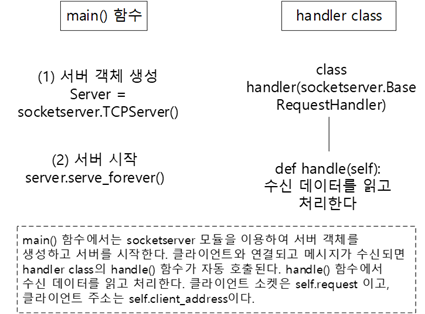

### socketserver 모듈을 사용한 TCP 서버 프로그램

socketserver.TCPServer 클래스를 이용하여 서버 객체를 생성하고 핸들러 클래스를 정의하여 작성
```
class socketserver.TCPServer(server_address, RequestHandlerClass, bind_and_activate=True)
```

  + server_address: (host, port)  
  + RequestHandlerClass: 핸들러 클래스
    + 클라이언트에서 데이터가 도착하면 핸들러 클래스의 handle() 메서드가 실행  
  + bind_and_activate: True이면 연결과정이 자동 처리됨
  

#### socketserver 모듈을 이용한 TCP 에코 서버 프로그램

1. socketserver.TCPServer 클래스를 이용하여 클라이언트의 연결 수락
2. BaseRequestHandler 클래스에서 상속된 핸들러 클래스를 정의하고 메서드를 재정의


In [ ]:
#socketserver_TCPServer.py
# socketserver 모듈을 이용한 echo 서버
import socketserver

#핸들러 클래스
class TCPHandler(socketserver.BaseRequestHandler):
    #데이터 수신 메서드
    def handle(self): 
        #self.request = 클라이언트 소켓
        self.data = self.request.recv(1024).strip()
        #self.client_address = 클라이언트 주소
        print(("{} wrote:".format(self.client_address[0])))
        print((self.data))
            
        # 수신 메시지 전송
        self.request.sendall(self.data.upper())
            
if __name__ == "__main__":
    HOST, PORT = "", 2500
    # 서버 객체 생성
    server = socketserver.TCPServer((HOST, PORT), TCPHandler, bind_and_activate=True)

    # 서비스를 계속한다
    server.serve_forever()

**[실행 방법]**  
socketserver_TCPserver.py 서버 프로그램을 먼저 실행하고 TCP_client.py 클라이언트 프로그램을 실행한다. 클라이언트에서 메시지를 입력하면 서버로 전송되고 서버로부터 같은 메시지를 받게 된다.  

서버가 실행 중인 상태에서 클라이언트 프로그램을 하나 더 실행해 보자. 두 번째 클라이언트도 자신이 보낸 메시지를 그대로 받을 수 있다. 그러나 첫 번째 클라이언트의 연결은 해제되므로 더 이상 데이터를 송수신할 수 없다.   

서버는 server.serve_forever() 함수에 의해 클라이언트의 요청을 받고 핸들러 클래스에게 처리를 넘기는 동작을 반복한다. 그러나 핸들러 클래스의 handle() 메서드는 한 번 실행 후 반환된다.

**[연습문제 12-6]**  
(1) TCPHandler 클래스에서 setup() 메서드를 재정의하여 "연결되었습니다"라는 메시지를 출력하고, finish() 메서드를 재정의하여 "연결이 해제되었습니다"라는 메시지가 출력되도록 서버 프로그램을 수정하시오.  

(2) 서버 프로그램의 handle() 함수는 클라이언트가 접속하면 한 번만 실행된다. 따라서 클라이언트에서 계속 메시지를 보내면 에러가 발생한다. 연속적인 메시지 송수신이 가능하도록 handle() 프로그램을 수정하시오.(힌트: handle()에서 계속 처리가 되도록 while True: 문장을 추가한다)  

(3) 제11장에서 설명한 요청 처리 서버(TCP_process_server.py)를 socketsever 모듈을 이용하여 작성하시오.

### socketserver 모듈을 사용한 UDP 서버 프로그램

socketserve.UDPServer 클래스를 이용한 에코 서버 프로그램  
```
class socketserver.UDPServer(server_address, RequestHandlerClass, bind_and_activate=True)
```
+ UDP 서버는 연결이 없기 때문에 클라이언트의 연속 서비스가 가능하다  
+ UDP 서버에서 self.request 인수턴스 변수의 기능  (TCP 서버와 다름)
    + self.request[0]: 수신 데이터  
    + self.requests[1]: 클라이언트 소켓
    + client_address: 상대방 주소

In [ ]:
#socketserver_UDPserver.py
#socketserver 모듈을 이용한 UDP 에코 서버 프로그램

import socketserver

#핸들러 클래스
class UDPHandler(socketserver.BaseRequestHandler):
    #데이터가 수신되면 한번 실행됨
    def handle(self):
        # 수신 데이터 화면 출력
        #data = self.request[0], socket = self.request[1]
        #address = self.client_address
        data = self.request[0].strip() #수신 데이터
        socket = self.request[1] #연결 소켓
        print("{} wrote:".format(self.client_address[0]))
        print(data)
        
        #재전송
        socket.sendto(data.upper(), self.client_address) 

if __name__ == "__main__":
    HOST, PORT = "", 2500
    
    #UDP 소켓을 생성하고 클라이언트 서비스 실행
    with socketserver.UDPServer((HOST, PORT), UDPHandler) as server:
        server.serve_forever()

**[실행 방법]**  
서버 프로그램을 실행하고 클라이언트(UDP_client.py)를 실행한다

**[연습문제 12-7]**  
11장에서 설명한 1:1 UDP 채팅 서버 프로그램(UDP_chat_server.py)을 socketserver 모듈을 이용하여 작성하시오. 동작 확인을 위한 클라이언트 프로그램은 UDP_chat_client.py를 사용하시오.

### socketserver.ThreadingMixIn 클래스를 이용한 멀티 클라이언트 지원 서버

socketserver.TCPServer 클래스의 문제점  
+ 단일 스레드로 실행되므로 한 번에 하나의 클라이언트만 서비스한다  

멀티 클라이언트를 서비스하려면 socketserver.ThreadingMixIn 클래스와 TCPServer 또는 UDPServer 클래스를 부모 클래스로 갖는 파생 클래스를 정의하여 사용한다
```
class ThreadedTCPServer(socketserver.ThreadingMixIn, socketserver.TCPServer):
	  pass
```
<ThreadingMixIn 클래스를 이용한 멀티 클라이언트 서버 동작>   
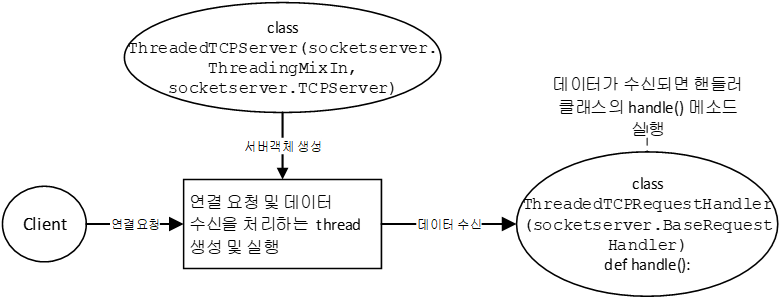

ThreadedTCPServer 파생 클래스로 thread 서버를 만들고 클라이언트 연결을 받아 요청처리 클래스에게 처리를 넘긴다. thread 서버가 연속적인 연결 서비스를 할 수 있도록 server.serve_forever() 함수를 실행한다.  

```
server = ThreadedTCPServer((HOST, PORT), ThreadedTCPRequestHandler)
server_thread = threading.Thread(target=server.serve_forever)
server_thread.start()
```

In [ ]:
#socketserver_ThreadingMixIn.py
#ThreadingMixIn을 이용한 비블록킹 소켓 TCP 에코 서버 프로그램

import socket
import threading
import socketserver

#소켓 요청 처리 클래스
class ThreadedTCPRequestHandler(socketserver.BaseRequestHandler):
    def handle(self):
        data = str(self.request.recv(1024), 'utf-8') #self.request = 소켓
        cur_thread = threading.current_thread() #실행 스레드
        response = bytes("{}: {}".format(cur_thread.name, data), 'utf-8')
        self.request.sendall(response) #서버 응답 전송

#서버 객체 생성 클래스
class ThreadedTCPServer(socketserver.ThreadingMixIn, socketserver.TCPServer):
    pass

#클라이언트 함수
def client(ip, port, message):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
        sock.connect((ip, port))
        sock.sendall(bytes(message, 'utf-8'))
        response = str(sock.recv(1024), 'utf-8')
        print("수신: {}".format(response))

In [ ]:
if __name__ == "__main__":
    
    host, port = "localhost", 2500
    
    #서버 객체를 생성하고 요청 처리 클래스 지정
    server = ThreadedTCPServer((host, port), ThreadedTCPRequestHandler)
    
    #서버를 위한 스레드 생성과 실행
    ip, port = server.server_address #서버 주소와 포트
    server_thread = threading.Thread(target=server.serve_forever) #스레드 생성
    server_thread.daemon = True
    server_thread.start()
    print(f"{server_thread.name} 스레드에서 서버 실행")
    
    #클라이언트 호출
    client(ip, port, "안녕하세요 1")
    client(ip, port, "안녕하세요 2")
    client(ip, port, "안녕하세요 3")

    server.shutdown() #서버 종료

**[실행 방법]**  
프로그램 내부에 클라이언트 객체를 생성하고 서버에 접속하여 메시지를 보내는 부분이 포함되어 있으므로 이 프로그램만 실행하면 된다. 각 클라이언트가 별도의 스레드 서버에 의해 서비스되는 것을 알 수 있다.

**[연습문제 12-8]**  
내부 클라이언트를 호출하지 않고 TCP_client.py 클라이언트 프로그램과 통신 할 수 있도록 서버 프로그램을 
수정하시오. 

### socketserver의 멀티스레드 클래스를 이용한 에코 서버

멀티스레드 서버를 위한 서버 객체 생성 클래스  
* class socketserver.ThreadingTCPServer
* class socketserver.ThreadingUDPServer

요청 처리를 위한 핸들러 클래스(BaseRequestHandler 클래스의 파생 클래스)
* socketserver.StreamRequestHandler
* socketserver.DatagramrequestHandler

핸들러 클래스에서 데이터 수신와 송신 방법
* self.rfile.read() 또는 self.rfile.readline() 함수를 이용하여 수신
* self.wfile,write() 함수를 이용하여 송신

In [ ]:
#ThreadingMixIn_echo_server.py
#ThreadingMixIn + TCPServer 클래스를 이용한 멀티 클라이언트 에코 서버
import socketserver
import threading

#핸들러 클래스
class RequestHandler(socketserver.StreamRequestHandler):
    def handle(self): #요청 처리 메소드
        client = f'{self.client_address} on {threading.currentThread().getName()}'
        print(f'Connected: {client}')
        
        #수신 데이터를 출력하고 다시 송신한다
        while True:
            data = self.rfile.readline() #데이터 수신
            if not data:
                break
            print(data.decode())
            self.wfile.write(data) #데이터 송신
        print(f'Closed: {client}')

#멀티스레드 서버 객체 생성
with socketserver.ThreadingTCPServer(('', 2500), RequestHandler) as server:
    print(f'The echo server is running...')
    server.serve_forever() #연속 서비스 수행

**[실행 방법]**  
이 서버와 함께 클라이언트를 실행할 때 메시지와 함께 “\r\n”을 전송해야 한다.
TCP_client.py 프로그램에서 송신 메시지에 “\r\n”을 추가하여 송신하도록 수정하여 서버와 함께 실행한다. 여러 개의 클라이언트를 동시에 실행하여 모두 서비스되는지 확인해 보자.

### socketserver.ThreadingMixIn과 http.server 모듈을 이용한 감시 카메라 구현
**(내용이 어려우므로 생략 가능)**  

컴퓨터에 웹캠을 설치하고 촬영된 영상을 웹브라우저에 표시하여 감시 카메라를 구현하는 프로그램

+ 이 프로그램은 서버 객체를 생성하기 위한 팩토리 클래스와 이벤트 처리를 위한 프로토콜 클래스가 필요하다.

+ 팩토리 클래스(Factory Class)  
  + 멀티 클라이언트를 지원하기 위해 socketserver.ThreadingMixIn과 http.server.HTTPServer 클래스를 상속하여 정의하며 서버 객체 생성을 위해 사용된다    
+ 프로토콜 클래스(Protoco Class)
  + http.server.BaseHTTPRequestHandler를 상속하여 정의하며 클라이언트 요청을 처리하는 핸들러 클래스이다  
```python
#서버 객체 생성을 위한 팩토리 클래스
class StreamingServer(socketserver.ThreadingMixIn, server.HTTPServer):
    # socketserver 속성. 주소 재사용
    allow_reuse_address = True 
    # ThreadingMixIn 속성. 서브 스레드가 종료되면 즉시 종료
    daemon_threads = True  
```
```
#웹브라우저에서 클라이언트 요청을 처리하기 위한 프로토콜 클래스
class StreamingHandler(server.BaseHTTPRequestHandler):
    #클라이언트(웹브라우저) 요청 처리
    def do_GET(self):
        #영상을 받아 브라우저에 표시한다
```

+ Condition 객체를 이용한 공유 자원에 대한 스레드 동기화 방법  
  카메라 프레임 이미지가 준비되면 Condition 객체를 이용하여 신호를 보내고, WebServer에서는 신호가 오면 이미지를 읽어 브라우저에 표시한다  
  + Condition 객체 생성  
    cond = threading.Condition()  
  + 다른 스레드에서 신호를 줄 때까지 기다린다  
    cond.wait()
  + 공유 자원이 준비되면 신호를 보낸다  
    cond.notifyAll()  


+ 동기에 맞춰서 이미지를 frame 버퍼에 저장하는 클래스  
```  
class StreamingOutput(object):
    def __init__(self):

    def write(self, buf):
       # 영상을 버퍼에 저장
       # 공유 자원(버퍼) 준비 완료 통보
```  

**메인 함수**  
+ 카메라 영상을 frame 버퍼에 저장한다  
  vid = cv2.VideoCapture(0)  
  output = StreamingOutput()  
+ WebCam 영상을 연속적으로 버퍼로 전송하는 스레드  
  v_th = threading.Thread(target=record, args=())  
  v_th.daemon = True  
  v_th.start()  
+  server 객체를 생성하고 thread로 실행  
  address = ('', 8000)  
  server = StreamingServer(address, StreamingHandler)   
  server.serve_forever()  

In [ ]:
#WebCam_Browser.py
import logging
import socketserver, cv2, imutils, threading
from threading import Condition
from http import server

#웹 페이지 HTML
PAGE="""\
<html>
<head>
<title>WebCam streaming demo</title>
</head>
<body>
<h1>WebCam Streaming Demo</h1>
<img src="stream.mjpg" width="640" height="480" />
</body>
</html>
"""

In [ ]:
# WebCam 영상을 jpg로 변환하여 버퍼에 저장
def record():
    global vid, output

    while vid.isOpened():
        #이미지를 읽어온다
        img, frame = vid.read()
        #이미지 크기 조정
        frame = imutils.resize(frame, width=640) # numpy array type
        #이미지를 jpg로 압축한다
        _, jpg = cv2.imencode(".jpg", frame)
        #압축된 이미지를 버퍼에 저장한다
        output.write(jpg)

In [ ]:
#스레드 사이의 동기화를 위한 조건변수(Condition 객체)를 설정하고
#압축 이미지를 frame 버퍼에 저장한다
class StreamingOutput(object):
    def __init__(self):
        self.frame = None
        # 조건변수 설정. thread 사이의 동기화를 위해 사용
        self.condition = Condition() 

    def write(self, buf):
        # 스레드 동기에 맞추어 압축 영상을 frame 버퍼에 저장
        with self.condition:
            self.frame = buf 
            self.condition.notify_all() # 조건변수 충족 통지

In [ ]:
#영상 프레임을 웹브라우저에 표시하는 웹 서버 클래스(프로토콜 클래스)
class StreamingHandler(server.BaseHTTPRequestHandler):
    # GET Server
    def do_GET(self):
        if self.path == '/':
            self.send_response(301)
            self.send_header('Location', '/index.html')
            self.end_headers()
        elif self.path == '/index.html':
            content = PAGE.encode('utf-8')
            self.send_response(200)
            self.send_header('Content-Type', 'text/html')
            self.send_header('Content-Length', len(content))
            self.end_headers()
            self.wfile.write(content) # Web browser에 응답 전송
        
        elif self.path == '/stream.mjpg': # <img src="stream.mjpg" width="640" height="480" />
            self.send_response(200)
            self.send_header('Age', 0)
            self.send_header('Cache-Control', 'no-cache, private')
            self.send_header('Pragma', 'no-cache')
            self.send_header('Content-Type', 'multipart/x-mixed-replace; boundary=FRAME')
            self.end_headers()
            try:
                while True:
                    #스레드 동기에 맞추어 frame을 가져온다
                    with output.condition:
                        # frame이 준비될 때까지 기다린다
                        output.condition.wait() 
                        # frame을 가져온다
                        frame = output.frame 
                    self.wfile.write(b'--FRAME\r\n')
                    self.send_header('Content-Type', 'image/jpeg')
                    self.send_header('Content-Length', len(frame))
                    self.end_headers()
                    self.wfile.write(frame) # web browser에게 frame 전송
                    self.wfile.write(b'\r\n')
            except Exception as e:
                logging.warning(
                    'Removed streaming client %s: %s',
                    self.client_address, str(e))
        
        else:
            self.send_error(404)
            self.end_headers()

In [ ]:
#서버 객체 생성 클래스(팩토리 클래스)
class StreamingServer(socketserver.ThreadingMixIn, server.HTTPServer):
    allow_reuse_address = True # socketserver 속성. 주소 재사용
    daemon_threads = True # ThreadingMixIn 속성. 서브 스레드가 종료되면 즉시 종료

#WebCam에서 이미지 획득
vid = cv2.VideoCapture(0)
output = StreamingOutput()

# WebCam 영상을 연속적으로 버퍼로 전송하는 스레드
v_th = threading.Thread(target=record, args=())
v_th.daemon = True
v_th.start()

# 다중 클라이언트 지원 서버 실행
try:
    address = ('', 8000)
    # server 객체를 생성하고 thread로 실행
    server = StreamingServer(address, StreamingHandler) 
    server.serve_forever()
finally:
    vid.release()

**[실행 방법]**  
컴퓨터에 웹캠을 설치하고 프로그램을 실행한다. 웹캠의 LED가 깜박일 때, 웹브라우저에 http://localhost:8000을 입력하면 동영상을 볼 수 있다.

## selectors 모듈을 이용한 소켓 프로그래밍

**중요도가 떨어지므로 생략**  

selectors 모듈은 이벤트 관리기이며, 소켓 이벤트와 콜백함수를 등록해두면 나중에 이벤트 발생 소켓, 이벤트 종류, 콜백함수를 확인할 수 있다.  
관리기 클래스의 메서드를 이용하여 등록, 삭제, 수정, 이벤트 확인을 할 수 있다  
+ selectors 모듈이 제공하는 이벤트 관리기 클래스는 다음과 같다  
  + SelectSelector  
  + PollSelector
  + EplooSelector
  + DevpollSelector
  + KqueueSelector
+ selectors 모듈의 DafualtSelector 클래스를 이용하면 운영 체제에 가장 적합한 이벤트 관리기를 선택할 수 있다
+ 이벤트 클래스 메서드  

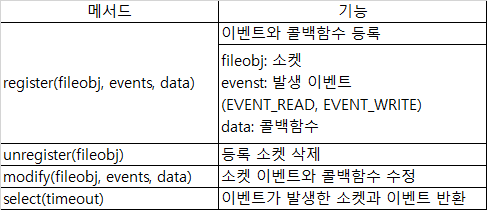

+ select() 메서드를 호출하면 (key, mask) 반환
  + key.filepbj: 소켓
  + key.data: 콜백함수
  + mask: EVENT_READ, EVENT_WRITE

**selector 모듈을 이용한 에코 서버 프로그램**  

In [ ]:
#slectors 모듈을 이용한 TCP 에코 서버 프로그램

import selectors
import socket

# EVENT_READ(연결)를 위한 콜백함수
def accept(sock, mask):
    c_sock, addr = sock.accept()  # 연결 수락
    print(f'{addr}에서 연결됨')
    c_sock.setblocking(False) #소켓은 넌블록킹 모드로 설정되어야 한다
    
    #연결 후에 읽기 이벤트가 발생하면 read() 함수를 실행하도록 설정
    sel.register(c_sock, selectors.EVENT_READ, read) 

# EVENT_READ(데이터 수신)를 위한 콜백함수
def read(c_sock, mask):
    try:
        data = c_sock.recv(1024)  # 데이터 수신
    except:
        print("연결 종료")
        sel.unregister(c_sock)
        c_sock.close()
        return
    if data:
        print('수신데이터: ', data.decode())
        c_sock.send(data)  # 송신자에게 재전송
    else:
        print(f'{c_sock} 소켓 닫음')
        sel.unregister(c_sock) #연결 종료
        c_sock.close()

In [ ]:
#기본 이벤트 관리기 선택
sel = selectors.DefaultSelector()

# 소켓을 생성하고 넌블로킹으로 설정
sock = socket.socket()
sock.bind(('', 2500))
sock.listen(5)
sock.setblocking(False) #넌블록킹 모드로 동작

#처음 읽기 이벤트(연결 요청)가 발생하면 accept() 함수를 실행하도록 설정
sel.register(sock, selectors.EVENT_READ, accept)

while True:
    events = sel.select(timeout=0) #이벤트 발생 대기(넌블로킹)
    
    #발생 이벤트를 조사하여 콜백 호출
    for key, mask in events:
        #sel.select()가 반환하는 key 객체의 data 속성은 콜백함수이다
        callback = key.data
        #key 객체의 fileobj 속성은 소켓이고, mask는 발생 이벤트이다
        callback(key.fileobj, mask) #콜백함수 호출

**selectors 모듈을 이용한 에코 클라이언트 프로그램**  

In [ ]:
#selectors 모듈을 이용한 TCP 클라이언트 프로그램

import selectors
import socket

sel = selectors.DefaultSelector()
keep_running = True
sendingmsg = [
    '두 번째 송신 메시지입니다',
    '첫 번째 송신 메시지입니다',
]
bytes_sent = 0
bytes_received = 0

# 연결 동작은 블록킹 모드이므로 연결 후에 비블록모드로 설정해야 한다
server_address = ('localhost', 2500)
print('연결 {} port {}'.format(*server_address))
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.connect(server_address)
sock.setblocking(False) #반드시 넌블록킹 모드로 설정

In [ ]:
# 읽기와 쓰기 이벤트를 모니터링하도록 이벤트 관리기(selector) 설정
# 각 이벤트가 발생하는 경우가 하나뿐이므로 콜백을 지정하지 않아도 된다
sel.register(
    sock,
    selectors.EVENT_READ | selectors.EVENT_WRITE,
)

while keep_running:
    print('\n입출력 대기')
    for key, mask in sel.select(timeout=1):
        e_sock = key.fileobj #이벤트가 발생한 소켓
        c_address = e_sock.getpeername() #장치의 주소 확인
        print('클라이언트({})'.format(c_address))

        if mask & selectors.EVENT_READ: #이벤트가 READ인지 확인
            print('  읽기 준비')
            data = e_sock.recv(1024) #소켓에서 데이터 읽기
            if data:
                # 읽기 이벤트 발생 소켓에서 데이터를 읽은 경우
                print('  수신 메시지 {}'.format(data.decode()))
                bytes_received += len(data)

            # data가 없으면 실행 종료
            keep_running = not (
                data or
                (bytes_received and
                 (bytes_received == bytes_sent))
            )

        if mask & selectors.EVENT_WRITE: #이벤트가 WRITE인지 확인
            print('  쓰기 준비')
            if not sendingmsg: #송신 메시지가 없으면
                print('  수신 모드로 전환')
                sel.modify(sock, selectors.EVENT_READ)
            else:
                # 메시지 송신
                send_msg = sendingmsg.pop()
                print('  전송 {!r}'.format(send_msg))
                sock.sendall(send_msg.encode())
                bytes_sent += len(send_msg)

print('종료')
sel.unregister(e_sock)
e_sock.close()
sel.close()

**[연습문제 12-9]**  
EVENT_READ와 EVENT_WRITE를 위한 콜백함수로 각각 read()와 write()를 사용하여 selector_echoclient.py 프로그램을 수정하시오

# asyncio 모듈을 이용한 소켓 프로그래밍

+ asyncio는 비동기 프로그램을 작성하기 위한 라이브러리이다  
  비동기란 여러 개의 작업이 동시에 진행되는 것을 의미한다  
  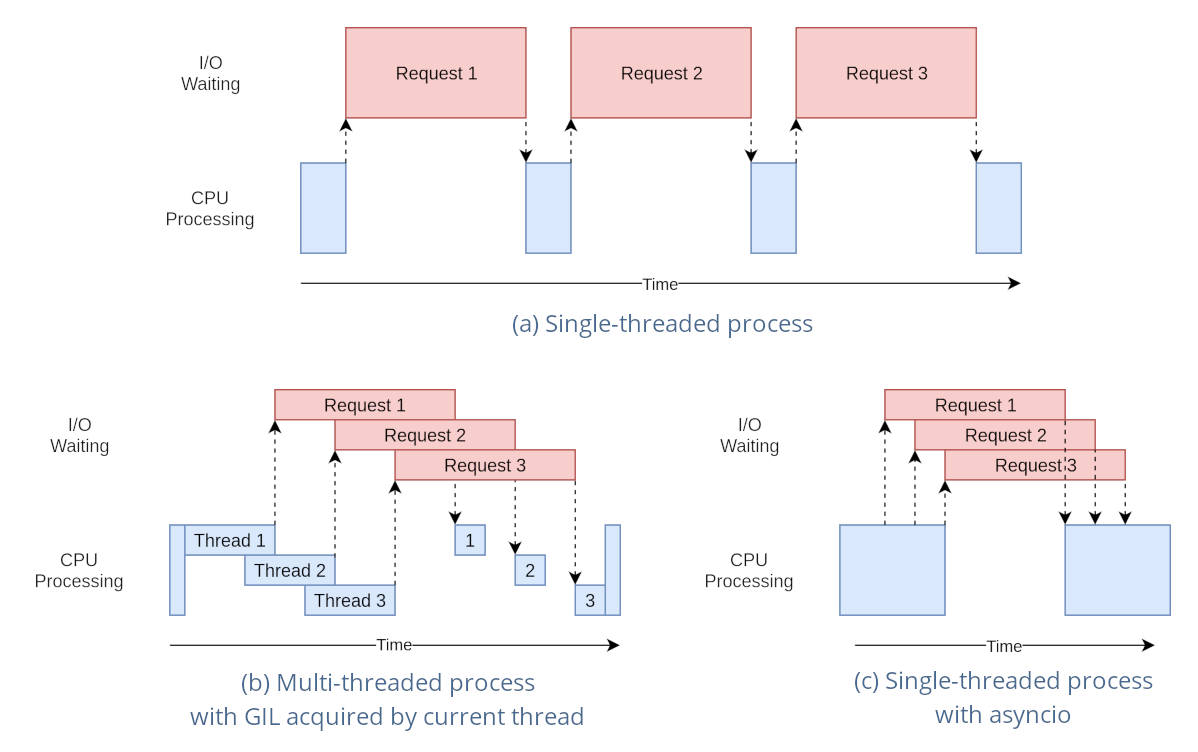
  <출처: https://devopedia.org/asynchronous-programming-in-python>  


+ asyncio의 비동기 동작은 코루틴(coroutine)과 이벤트 루프(event loop)를 통해 이루어진다
  + 코루틴: 일시 중지나 재시작을 할 수 있는 비동기 함수. 실행하면 코루틴 객체가 반환됨
  + 이벤트 루프: 무한 루프를 돌며 매 루프마다 작업을 하나씩 실행시키는 도구이며 코루틴을 스캐줄링(실행 예약)하고 실행되도록 하는 메커니즘
  + 이벤트 루프에 코루틴 객체를 스케줄링하고 실행하며 코루틴끼리 협력하여 멀티태스킹을 수행한다.

## 코루틴과 생성과 실행

코루틴을 생성하고 이벤트 루프에 스캐줄링(실행 예약)하는 방법
+ 코루틴은 async def으로 정의됨
+ 코루틴 내부에서 다른 코루틴은 await로 호출(코루틴이 아닌 일반 함수에서는 코루틴을 호출할 수 없다!!!)
+ 일반 프로그램에서 코루틴을 처음 호출하려면 asyncio.run()을 이용함

In [ ]:
import asyncio
import time

#코루틴 정의
async def say(msg, delay):
    #다른 코루틴 호출
    await asyncio.sleep(delay)
    print(msg)

#코루틴 진입점
#asyncio.run(say("Hello World", 1))
say("Hello World", 1)

**[실행 방법]**  
주피터 노트북이 이벤트 루프에서 실행되므로 예제 프로그램을 이벤트 루프에서 실행하면 오류가 발생한다. **VS Code에서 독립적인 파일로 작성하여 실행**해 보자. 앞으로 예제 프로그램은 모두 이러한 방법으로 실행해야 한다.

## 이벤트 루프로 코루틴 실행하기

일반 함수에서 코루틴에 진입하려면 앞에서 설명한 asyncio.run()외에 이벤트 루프를 이용할 수 있다.
1. asyncio.get_running_loop() 함수로 실행 이벤트 루프를 가져온다  
2. 실행 이벤트 루프가 없으면 asyncio.new_event_loop() 함수로 이벤트루프를 생성한다
3. loop.run_until_complete(코루틴) 함수를 호출하여 코루틴을 이벤트 루프에 스케줄링(실행 예약)하고 실행한다

In [ ]:
import asyncio
import time

async def say(msg, delay):
    await asyncio.sleep(delay)
    print(msg)

try:
    loop = asyncio.get_running_loop()
except:
    loop = asyncio.new_event_loop()

print(f"started at {time.strftime('%X')}")
asyncio.run_coroutine_threadsafe(say('Hello World', 1), loop)
#loop.run_until_complete(say('Hello World', 1))
print(f"started at {time.strftime('%X')}")

#loop.close()

### 이벤트 루프로 멀티 코루틴 실행하기
코루틴은 병행 실행이 가능하므로 이벤트 루프를 이용하여 멀티 코루틴을 실행할 수 있다  

**(1) 태스크를 만들어 멀티 코루틴 실행**  
loop.create_task()를 사용하여 코루틴의 태스크를 생성하고, loop.run_until_complete()를 사용하여 실행한다  
```
task1 = loop.create_task(say('First hello', 2))
task2 = loop.create_task(say('Second hello', 3))

loop.run_until_complete(task1)
loop.run_until_complete(task2)
```

In [ ]:
#multi_conroutine.py
#태스크를 만들어 다수의 코루틴을 병행 실행하는 프로그램

import asyncio
import time

#코루틴
async def say(msg, delay):
    await asyncio.sleep(delay)
    print(msg)

#현재 이벤트 루프를 가져온다
try:
    loop = asyncio.get_running_loop()
except:
    loop = asyncio.new_event_loop()
print(f"started at {time.strftime('%X')}")

#태스크 생성
task1 = loop.create_task(say('First hello', 2))
task2 = loop.create_task(say('Second hello', 3))

#태스크가 실행완료될 때까지 루프 실행
loop.run_until_complete(task1)
loop.run_until_complete(task2)
print(f"finished at {time.strftime('%X')}")

loop.close()

**[실행 결과]**  
started at 22:14:27  
First hello  
Second hello  
finished at 22:14:30  

태스크를 이용하여 두 개의 코루틴이 병행 실행되므로 총 소요시간이 5초가 아니라 3초이다. 

**(2) asyncio.gather()를 이용한 실행**  
asyncio.gather(*task_list)를 이용하면 복수의 태스크나 코루틴을 한 번에 실행하고 결과도 한꺼번에 반환받을 수 있다. task_list는 실행할 태스크나 코루틴 리스트이다

In [ ]:
#asyncio_gather.py
#asyncio.gather(*coros)를 이용한 동시 실행 프로그램
#Python 3.7+
 
import asyncio
import random
import time

#코루틴
async def say(msg, delay=1):
    print(f'{msg!r} will be displayed in {delay} seconds')
    await asyncio.sleep(delay)
    return msg.upper()

#메인 코루틴
async def main():
    messages = 'hello world apple banana cherry'.split()
    #지연 시간을 달리하여 코루틴 호출
    cos = [say(m, random.randrange(1,5)) for m in messages]
    
    start_time = time.time() #시작 시각
    #코루틴 리스트에 있는 코루틴 객체가 모두 종료되어야 반환됨
    #따라서 코루틴을 호출할 때 가장 지연 시간이 긴 코루틴이 종료되어야 반환됨
    results = await asyncio.gather(*cos) 
    
    print(results)
    print(f'{time.time() - start_time}') #총 소요시간
        
#코루틴 진입
asyncio.run(main())

**(3) asyncio.as_completed()를 이용한 실행**  
코루틴 리스트 또는 태스크 리스트를 만들고 asyncio.as_completed()를 실행하면 먼저 완료된 코루틴부터 반환된다. 완료되지 않은 코루틴이 있어도 먼저 완료된 코루틴부터 결과가 반환된다.

In [ ]:
#asyncio_as_completed.py
# 여러 개의 코루틴을 동시에 스케줄링하고 완료된 순서대로 결과를 반환
 
import asyncio
import random

#코루틴
async def lazy_greet(msg, delay=1):
    print(f'{msg!r} will be displayed in {delay} seconds')
    await asyncio.sleep(delay)
    return msg.upper()

#메인 코루틴
async def main():
    messages = 'pear peach apple banana cherry'.split()
    
    #코루틴 리스트
    cos = [lazy_greet(m, random.randrange(1,5)) for m in messages]
    
    #코루틴을 스케줄링하고 완료되는 코루틴을 차례대로 반환
    for coro in asyncio.as_completed(cos):
        #coro = 완료된 코루틴
        #await로 완료된 코루틴의 결과를 반환받는다
        msg = await coro
        print(msg)

asyncio.run(main())

**(4) asyncio.wait()를 이용한 실행**  
코루틴 리스트를 만들고 asyncio.wait()를 호출하면 (done, pending)이 반환된다. done은 완료된 코루틴 집합이고, pending은 미완료 코루틴 집합이다. 이 함수도 코루틴이 모두 완료되어야 결과가 반환된다.

In [ ]:
#asyncio_wait.py
# asyncio.wait(coros)를 이용한 복수 코루틴 실행 프로그램
# Python 3.7+
 
import asyncio
import random
import time
 
async def say(msg, delay=1):
    print(f'{msg!r} will be displayed in {delay} seconds')
    await asyncio.sleep(delay)
    return msg.upper()
 
async def main():
    messages = 'hello world apple banana cherry'.split()
    cos = [say(m, random.randrange(1,5)) for m in messages]
    
    #코루틴을 스케줄링하고 완료된 태스크 집합과 미완료 태스크 집합을 반환받는다
    #await를 호출하여 코루틴의 실행 결과를 반환받는다
    start_time = time.time() #시작 시각
    done, pending = await asyncio.wait(cos) #코루틴을 한 번에 스케줄링
    
    for task in done: #완료된 태스크의 깂을 반환받는다
        print(await task)
    print(f'{time.time() - start_time}') #총 소요시간
        
asyncio.run(main())

### 일반 함수를 비동기로 실행하기
일반 함수를 비동기로 실행하면 입출력을 포함하는 프로그램의 실행 시간을 줄이거나 다른 코루틴과 함께 실행하여 병행 실행이 가능하다.
+ 실행 방법
```
loop = asyncio.get_running_loop()
await loop.run_in_executor(executor, ftn, params)
```
  + executer: 실행 스레드. None으로 지정
  + ftn: 호출할 일반 함수
  + params: 일반 함수의 인자

일반 함수를 비동기 실행했을 때 실행 시간 단축 예  
https://dojang.io/mod/page/view.php?id=2469

In [ ]:
#asyncio_func_call.py
# 일반 함수를 비동기로 실행하는 프로그램

import asyncio as aio

#3초 마다 숫자 출력
async def coro1(): 
    i = 1
    while True:
        print(i)
        i = i + 1
        await aio.sleep(3)

#일반 함수를 비동기로 실행
async def coro2(loop): 
    while True:
        #input() 함수를 비동기로 실행하여 메시지 입력
        msg = await loop.run_in_executor(None, input, ': ')
        print('->',msg)

#코루틴과 일반 함수를 병행 실행한다
async def main():
    try:
        loop = aio.get_running_loop() #코루틴에서 이벤트 루프를 얻을 때
    except:
        loop = aio.new_event_loop()
    task1 = loop.create_task(coro1())
    task2 = loop.create_task(coro2(loop))
    
    #코루틴, 테스크를 await로 실행
    await task1
    await task2

aio.run(main())

### 이벤트 루프 종료하기
asyncio의 이벤트 루프는 loop.run_forever() 함수로 무한 반복 실행된다. 이벤트 루프를 중단하려면 loop.stop()을 호출한다.

In [ ]:
#stop_coroutine.py
# 코루틴 중지 프로그램

import asyncio

#코루틴
async def say(what, delay):
    await asyncio.sleep(delay)
    print(what)

#이벤트 루프를 중지시키는 코루틴
async def stop_after(loop, delay):
    await asyncio.sleep(delay)
    loop.stop()

try:
    loop = asyncio.get_running_loop()
except:
    loop = asyncio.new_event_loop()

#태스크를 생성하고 이벤트 루프에 스캐줄링한다
loop.create_task(say('first message', 2))
loop.create_task(say('second message', 1))
loop.create_task(say('third message', 4))
#3초 후에 loop가 중지되므로 3번째 태스크는 완료되지 않는다
loop.create_task(stop_after(loop, 3))

#이벤트 루프 반복 실행
loop.run_forever()
loop.close()

## asyncio 모듈을 이용한 소켓 통신
asyncio를 이용한 소켓 통신 방법  
+ 스트림 통신
  + TCP 통신
+ 소켓 이벤트 통신
  + TCP 통신
  + UDP 통신  

<통신 방법에 따른 사용 함수>  
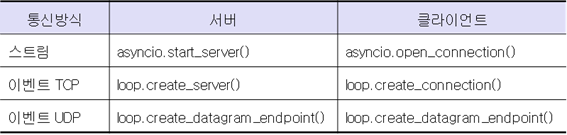

### start_server()를 이용한 TCP 에코 서버
+ asyncio.start_server() 함수는 콜백 함수를 인수로 전달받아 서버 객체를 생성하고 클라이언트와 연결한다. 
+ 클라이언트와 연결되면 콜백 함수가 호출되고 StreamReader 객체인 reader와 StreamWriter 객체인 writer가 콜백 함수의 인수로 전달된다. 
+ 콜백 함수에서 reader.read()와 writer.write() 함수를 사용하여 데이터를 송수신한다.  
```
coroutine asyncio.start_server(client_connected_cb, host=None, port=None, *, loop=None, limit=None, **kwds)  
```
```
async def callback():
    #body
serverObj = asyncio.start_server(callback, '127.0.0.1', 2500, loop=loop)
```

In [ ]:
#asyncio_tcp_echo_server.py
# start_server()를 이용한 TCP 에코 서버 프로그램

import asyncio

#데이터 수신 처리 코루틴
#클라이언트와 연결되면 한 번만 실행됨
async def handle_echo(reader, writer): 
    #데이터 수신
    data = await reader.read(100) 
    message = data.decode()
    
    #상대방 주소
    addr = writer.get_extra_info('peername') 
    print(f"{addr!r}에서 {message!r}를 수신함")
        
    #데이터 송신
    print(f"송신: {message!r}")
    writer.write(data)
    #송신이 완료될 때까지 대기
    await writer.drain()
    print("클라이언트 소켓 닫음")
    writer.close()

svr = '127.0.0.1'
port = 2500
try:
    loop = asyncio.get_running_loop()
except:
    loop = asyncio.new_event_loop()

#클라이언트가 연결되면 handle_echo callback이 실행된다
coro = asyncio.start_server(handle_echo, svr, port, loop=loop) 
server = loop.run_until_complete(coro) #코루틴이 완료될 때까지 기다린다

print('Serving on {}'.format(server.sockets[0].getsockname()))

try:
    loop.run_forever() #계속 연결 서비스
except KeyboardInterrupt:
    pass

#서버 객체를 닫는다
server.close()
#서버 객체가 종료될 때까지 대기한다
loop.run_until_complete(server.wait_closed())
loop.close()

**[연습문제 12-10]**  
main 함수를 코루틴으로 정의하고 asyncio.run(main())을 이용하여 프로그램을 수정하시오. [힌트: await coro.serve_forever()를 이용하여 서버를 
실행한다]

### open_connection()을 이용한 TCP 에코 클라이언트
스트림을 이용한 TCP 에코 클라이언트 프로그램  
+ async.open_connection() 함수는 서버에 연결하여 스트림 통신을 하기 위한 코루틴
```
coroutine asyncio.open_connection(host=None, port=None, *, loop=None, limit=None, **kwds)
```
+ 서버와 연결되면 (reader, writer) 스트림 객체 쌍을 반환한다. 
+ reader는 StreamReader 클래스 객체이고, writer는 StreamWriter 클래스 객체이다.  
    + reader.read(buffer_size)
    + writer.write(data)


In [ ]:
#asyncio_tcp_echo_client.py
# open_connection()을 이용한 TCP 클라이언트 프로그램

import asyncio

#소켓을 생성하고 서버와 연결하는 코루틴
async def tcp_echo_client(message, loop):
    reader, writer = await asyncio.open_connection(
        'localhost', 2500)

    #데이터 송신
    print('송신: {!r}'.format(message))
    writer.write(message.encode()) #코루틴이 아님

    #메시지 수신(코루틴)
    data = await reader.read(100) 
    print('수신: {!r}'.format(data.decode()))
    
    print('연결 종료')
    #송신 연결 종료
    writer.close() 

message = 'Hello Server!'
#이벤트 루프를 가져온다
try:
    loop = asyncio.get_running_loop()
except:
    loop = asyncio.new_event_loop()

#이벤트 루프에서 코루틴 실행
loop.run_until_complete(tcp_echo_client(message, loop))

loop.close()

**[실행 방법]**  
서버 프로그램(asyncio_tcp_echo_server.py)을 먼저 실행하고 클라이언트 프로그램(asyncio_tcp_echo_client.py)을 실행한다.   
클라이언트 프로그램을 한 번 더 실행하여 동일한 결과를 얻을 수 있는지 확인해 보자. 서버에서 run_forever()에 의해 클라이언트 연결을 무한 반복적으로 허용하는 것을 알 수 있다.

**[연습문제 12-11]**  
(1) 연결된 클라이언트에게 계속 에코 서비스를 하도록 asyncio_tcp_echo_server.py를 수정하시오.   

(2) asyncio.run() 함수를 사용하여 asyncio_tcp_echo_client.py를 수정하시오.  

(3) asyncio_tcp_echo_client.py를 수정하여 채팅 클라이언트 프로그램을 작성하시오. 아래 그림과 같이 클라이언트 프로그램을 시작하면 자신의 이름을 입력하고 채팅을 시작한다. 상대방에게 보내는 메시지 앞에 이름을 추가하여 송신한다.   
채팅 서버 프로그램은 GUI_chatserver_multi.py를 사용하여 동작을 확인하시오.  
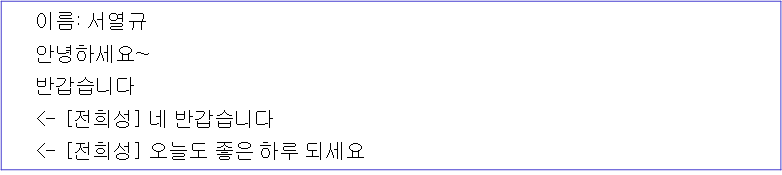  
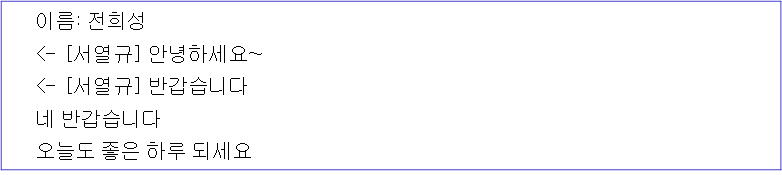

### start_server()와 open-connection()을 간단한 온라인 게임 프로그램

비동기 스트림 TCP 통신 함수를 이용하여 간단한 온라인 게임 프로그램  
+ 두 명의 클라이언트가 서버에 접속하고 클라이언트 화면에서 방향키를 이용하여 자신의 도형을 움직인다.  
+ 자신의 도형을 움직이면 상대방 화면의 도형도 같이 움직인다.  
+ pygame 모듈 이용(pip install pygame)  
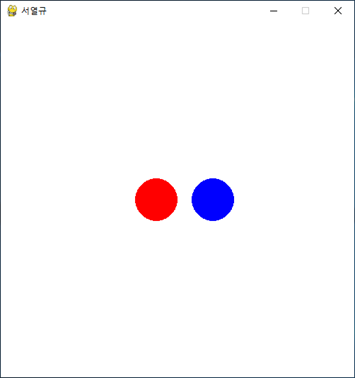

**게임 플레이어를 정의하는 사용자 모듈(game_player.py)**  
원의 중심, 반경, 색상을 정의하고 사용자가 누르는 방향키에 따라 원의 중심을 수정한다

In [ ]:
#game_player.py
import pygame

#게임 플레이어를 정의하는 클래스
class Player():
    def __init__(self, x, y, radius, color):
        self.x = x
        self.y = y
        self.radius = radius # 원의 반경
        self.color = color # 원의 색상
        self.center = (x,y) #원의 중심
        self.vel = 3 #이동 증분

    # 원을 그린다
    def draw(self, win):
        pygame.draw.circle(win, self.color, self.center, self.radius)

    # 방향키에 따라 원의 중심을 이동한다
    def move(self):
        # 눌러진 키를 읽어온다
        keys = pygame.key.get_pressed()

        # 방향키에 따라 원 중심의 x 또는 y좌표를 수정한다
        if keys[pygame.K_LEFT]:
            self.x -= self.vel

        if keys[pygame.K_RIGHT]:
            self.x += self.vel

        if keys[pygame.K_UP]:
            self.y -= self.vel

        if keys[pygame.K_DOWN]:
            self.y += self.vel

        # 수정된 x, y좌표값을 원의 중심으로 설정한다
        self.update()

    def update(self):
        self.center = (self.x, self.y)

**게임 서버 프로그램**  
Player 클래스 이용하여 두 개의 플레이어 객체를 생성하여 각 클라이언트에게 하나씩 할당하고 클라이언트가 자신의 정보가 저장되어 있는 객체를 전송해 오면 이를 다른 클라이언트에게 전송한다
+ asyncio_start_server()를 이용하여 서버 객체를 만들고 클라이언트 연결 대기
+ 연결 이후의 작업은 핸들러 코루틴에서 처리(무한 루프)
+ 핸들러 코루틴의 동작
  + 클라이언트가 새로 접속하면 플레이어 객체를 한 개 전송한다(플레이어 할당)  
    + 플레이어 객체를 전달받으면 속성을 알 수 있기 때문에 원을 그릴 수 있다
  + 클라이언트로부터 플레이어 객체를 수신하여 다른 클라이언트에게 송신하는 동작을 반복한다

In [ ]:
#game_async_server.py
import asyncio, pickle
from game_player import Player

# 두 명의 플레이어 객체 생성
players = [Player(220,250,30,(255,0,0)), Player(300,250, 30, (0,0,255))] #player for CIRCLE
currentPlayer = 0
svr = "127.0.0.1" # 서버 주소
port = 5555 # 포트

# 클라이언트가 연결되면 실행되는 코루틴
async def handler(reader, writer):
    global currentPlayer
    player = currentPlayer
    # 처음 연결된 클라이언트에게 플레이어 객체를 하나 전송
    writer.write(pickle.dumps(players[player])) 
    await writer.drain()
    
    currentPlayer += 1 # 다음 플레이어
    reply = ""
    
    # 클라이언트에게서 플레이어 객체를 수신하여 상대방에게 전송
    while True:
        try:
            # 플레이어 객체 수신
            data = pickle.loads(await reader.read(2048)) 
            # 플레이어 객체 저장
            players[player] = data

            if not data:
                print("Disconnected")
                break
            # 서로 성대방에게 전달
            else:
                if player == 1:
                    reply = players[0]
                else:
                    reply = players[1]

            # 다른 클라이언트에게 플레이어 객체 전송
            writer.write(pickle.dumps(reply)) 
            await writer.drain()
        except:
            break

    print("Lost connection")
    writer.close()


# 서버 객체를 만들고 연결을 기다린다. 이 과정은 무한 반복된다
async def main():
    server = await asyncio.start_server(handler, host=svr, port=port)
    async with server:
        await server.serve_forever()
    
asyncio.run(main())

**게임 클라이언트 프로그램**  
asyncio.open_connection()을 이용하여 서버와 연결하고, 연결되면 자신의 플레이너 객체를 수신한 후에, 다음 동작을 무한 반복한다.
+ 수신한 객체를 서버로 전송하고 상대방의 객체를 전달받는다.
+ 방향키에 따라 자신의 위치를 수정하고, 수정 위치에 자신의 원과 상대방 원을 그린다

In [ ]:
#game_async_client.py
import asyncio
import pygame, pickle
from game_player import Player

# 플레이어 객체를 이용하여 도형을 그린다
def redrawWindow(win, player, player2):
    win.fill((255,255,255))
    player.draw(win)
    player2.draw(win)
    pygame.display.update()

# 서버에 연결하고 플레이어 객체를 송수신하여 도형을 다시 그리는 무한 코루틴
async def conn_handler(run, host="localhost"):
    #서버에 연결하고 reader, writer 객체를 반환받는다
    reader, writer = await asyncio.open_connection(host, 5555) 
    # 자신에게 할당된 플레이어 객체를 수신한다
    pos = await reader.read(2048) 
    pos1 = pickle.loads(pos)
    clock = pygame.time.Clock()
    
    while run:
        #60프레임
        clock.tick(60)
        
        # 자신의 플레이어 객체를 전송한다
        writer.write(pickle.dumps(pos1)) 
        await writer.drain()
        
        # 상대방 플레이어 객체를 수신한다
        pos2 = await reader.read(2048) 

        # 윈도우 종료 버트(X)를 누르면 게임을 종료한다
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                run = False
                pygame.quit()

        pos1.move() # 방향키에 따라 자신의 위치 수정
        pos2 = pickle.loads(pos2)
        # 수정된 위치에 자신과 상대방의 도형을 다시 그린다
        redrawWindow(win, pos1, pos2) 

# 게임 화면 설정
width = 500
height = 500
win = pygame.display.set_mode((width, height))
name = input("Your name: ")
pygame.display.set_caption(name)

host = "localhost" # 서버 주소
run = True

asyncio.run(conn_handler(run, host))

**[실행 방법]**  
게임 서버를 먼저 실행하고 게임 클라이언트를 두 번 실행한다. 클라이언트에서 방향키로 원을 이동하면 상대방 클라이언트 화면에서도 원이 이동하는지 확인한다.

## 고수준 클라이언트/서버 프로그램
이벤트-콜백 모델을 이용하여 통신하는 고수준 함수를 이용한 프로그램
+ loop.create_server()  
  스트림 채널을 만드는 서버 함수  
+ loop.create_connection()  
  서버와 스트림으로 연결하는 함수  
+ loop.create_datagram_endpoint()  
  데이터 그램 채널을 만드는 함수

콜백 함수는 프로토콜 클래스에서 정의된다. 이벤크가 발생하면 이벤트 루프가 콜백 함수를 실행되고 콜백 함수의 인수는 이벤트 루프에 의해 전달된다

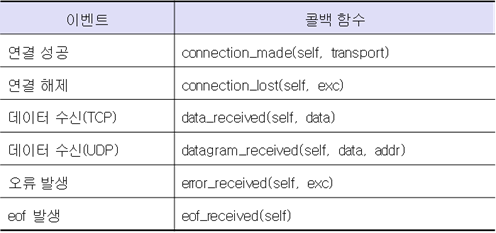

### create_datagram_endpoint()를 이용한 UDP 에코 서버 프로그램

UDP 에코 서버 프로그램을 작성하려면 loop.create_datagram_endpoint() 함수를 사용한다.  
```
loop = asyncio.get_running_loop()
transport, protocol = await loop.create_datagram_endpoint(protocol_factory, local_addr=('server_IP_addr', port))
```  
+ 인수
  + protocol_factory: 프로토콜 클래스 생성자 함수  
    예) lambda: protocol_class()
  + local_addr: (서버 IP 주소, 포트 번호)
+ 반환값
  + transport: 네트워크 연결 객체. 소켓과 같은 기능임
  + protocol: 프로토콜 클래스 객체  

프로토콜 클래스에서 소켓 이벤트에 대한 콜백 함수를 정의한다  
+ def connection_made(self, transport)
  + 연결이 성공하면 호출되는 콜백  
+ def datagram_received(self, data, addr)
  + 데이터를 수신하면 호출되는 콜백

In [ ]:
#asyncio_UDP_echo_server.py
#create_datagram_endpoint()를 이용한 이벤트 방식 서버 프로그램

import asyncio

#이벤트 콜백을 정의하는 프로토콜 클래스
class EchoServerProtocol:
    
    #연결이 성공하면 호출되는 콜백
    def connection_made(self, transport):
        self.transport = transport #소켓

    #데이터를 수신하면 호출되는 콜백
    #data(수신된 데이터)와 addr(상대방 주소)가 이벤트 루프에서 전달된다
    def datagram_received(self, data, addr):
        message = data.decode()
        print('Received %r from %s' % (message, addr))
        print('Send %r to %s' % (message, addr))
        self.transport.sendto(data, addr) #데이터 송신

async def main():
    print("Starting UDP server")

    # 현재의 이벤트 루프를 가져온다.
    try:
        loop = asyncio.get_running_loop()
    except:
        loop = asyncio.new_event_loop()

    #UDP 채널을 생성하고 protocol 객체를 콜백으로 지정한다
    #(transport, protocol) 객체가 반환된다.
    #transport는 소켓 객체이고,
    #protocol은 소켓 이벤트를 위한 callback이 정의된 클래스 객체이다
    transport, protocol = await loop.create_datagram_endpoint(
        lambda: EchoServerProtocol(),local_addr=('127.0.0.1', 2500))
    
    try:
        # asyncio.run()은 이벤트 루프에서 실행할 태스크가 없으면 종료된다. 
        # 이 문장은 이벤트 루프를 계속하기 위해 필요
        await asyncio.sleep(3600)  # 1시간 동안 서비스
    finally:
        transport.close()
    
asyncio.run(main())

**[실행 방법]**  
서버 프로그램을 실행하고 클라이언트 프로그램(UDP_client.py)을 실행한다. 두 개 이상의 클라이언트를 동시에 실행해도 에코 기능을 할 수 있는지 확인해 보자.

### create_datagram_endpoint()를 이용한 UDP 에코 클라이언트 프로그램

클라이언트 프로그램을 작성하려면 프로토콜 클래스를 정의하고 main 코루틴에서 현재 실행 이벤트 루프를 가져와 데이터그램 소켓 객체를 생성하고 실행한다.  

콜백 기반의 프로토콜 클래스와 비동기 코루틴의 상호 운용을 위해 퓨처(Future)가 사용된다. 프로토콜 클래스에서 퓨처 객체를 생성하고 모든 동작이 종료되면 퓨처 객체를 '완료'로 표시하여 비동기 코루틴에서 완료 여부를 알 수 있게 한다.  
+ \__init__(self, message, loop) 에서 초기화할 인스턴스 변수
  + self.message = message # 전송할 메시지
  + self.loop = loop # 이벤트 루프
  + self.transport = None # 소켓
  + self.on_con_lost = loop.create_future() # 퓨처 객체를 생성    
    연결이 종료되면 connection_lost(self, exc) 함수에서  
    self.on_con_lost.set_result(True)를 호출하여 실행 완료 표시
    main에서 await protocol.on_con_lost를 호출하여 연결이 해제되면 이벤트 루프 종료

In [ ]:
#asyncio_UDP_echo_client.py
#create_datagram_endpoint()를 이용한 이벤트 방식 클라이언트 프로그램

import asyncio

#이벤트 콜백을 정의하는 프로토콜 클래스
class EchoClientProtocol:
    def __init__(self, message, loop):
        self.message = message
        self.loop = loop
        self.transport = None
        self.on_con_lost = loop.create_future()
        
    #연결이 성공하면 호출되는 콜백
    def connection_made(self, transport):
        self.transport = transport #소켓
        print('Send:', self.message)
        self.transport.sendto(self.message.encode()) #데이터 전송

    #데이터를 수신하면 호출되는 콜백
    #data(수신된 데이터)와 addr(상대방 주소)가 이벤트 루프에서 전달된다
    def datagram_received(self, data, addr):
        print("Received:", data.decode())

        print("Close the socket")
        self.transport.close()

    #오류 발생 시 호출되는 콜백
    def error_received(self, exc):
        print('Error received:', exc)

    #연결이 종료되면 호출되는 콜백
    def connection_lost(self, exc):
        print("Connection closed")
        
        #연결이 종료되면 퓨처를 실행 완료로 설정하고 True 반환
        self.on_con_lost.set_result(True)


async def main():
    # 저수준 API를 사용하기 위해 현재 이벤트 루프를 가져온다
    loop = asyncio.get_running_loop()

    message = "Hello World!" #전송 메시지
    
    #UDP 채널을 생성하고 protocol 객체를 콜백으로 지정한다
    #(transport, protocol) 객체가 반환된다. transport는 소켓 객체이고,
    #protocol은 소켓 이벤트를 위한 callback이 정의된 클래스 객체이다
    transport, protocol = await loop.create_datagram_endpoint(
        lambda: EchoClientProtocol(message, loop),
        remote_addr=('127.0.0.1', 2500))

    try:
        #퓨처 객체 종료 대기
        await protocol.on_con_lost 
    finally:
        transport.close() #소켓을 닫는다

asyncio.run(main())

**[실행 방법]**  
서버 프로그램(asyncio_UDP_echo_server.py)을 실행하고 클라이언트 프로그램을 실행한다. 또 UDP_server.py를 실행하고 클라이언트를 실행해 보자.

### create_server()를 이용한 TCP 에코 서버 프로그램
TCP 서버는 loop.create_server(protocol_factory, host, port) 함수로 생성된다.
```
create_server(protocol_factory, host, port)
```
+ protocol_factory: 프로토콜 클래스 생성자
+ 반환값: asyncio.Server 객체 반환  

**프로그램 구성**  
```
async def main():
  #서버 객체 생성 및 서비스 시작
  
프로토콜 클래스(EchoServerProtocol)
  # 이벤트 콜백 함수 정의
  def connection_made(self, transport):
  def data_received(self, data):
```


In [ ]:
#asyncio_TCP_echo_create_server.py
#loop.create_server()를 이용한 TCP 에코 서버 프로그램

import asyncio

#이벤트 콜백을 정의하는 프로토콜 클래스
class EchoServerProtocol(asyncio.Protocol):
    
    #연결이 성공하면 호출되는 콜백
    #transport는 연결 소켓을 나타내고 이베트 루프에서 전달된다
    def connection_made(self, transport):
        #상대방 이름을 가져온다
        peername = transport.get_extra_info('peername')
        print('Connection from {}'.format(peername))
        self.transport = transport #소켓

    #데이터를 수신하면 호출되는 콜백
    #data(수신된 데이터)는 이벤트 루프에서 전달된다
    def data_received(self, data):
        message = data.decode()
        print('Data received: {!r}'.format(message))

        print('Send: {!r}'.format(message))
        self.transport.write(data) #데이터 송신

        #print('Close the client socket')
        #self.transport.close() #연속 서비스를 원하면 이 문장 삭제


async def main():
    # 저수준 API를 사용하기 위해 현재 이벤트 루프를 가져온다
    loop = asyncio.get_event_loop()

    #asyncio.Server 객체 생성
    server = await loop.create_server(
        lambda: EchoServerProtocol(),
        '127.0.0.1', 2500)
    print("Waiting for connection")
    
    async with server: #아래 블록 실행 완료 후 server 종료
        await server.serve_forever()#무한정 클라이언트 연결 허용

asyncio.run(main())

**[실행 방법]**  
서버 프로그램을 실행하고 클라이언트 프로그램(TCP_client.py)을 실행해 보자.

### create_server()를 이용한 GUI TCP 에코 서버 프로그램
클라이언트에서 받은 메시지를 엔트리 박스에 표시하고 다시 재전송하는 GUI 에코 서버 프로그램  

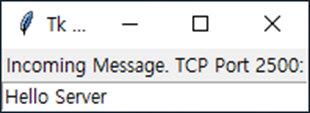  
**프로그램 구성**  
```
main():
  # 윈도우 객체 생성
  # 프로토콜 클래스 객체 생성
  
프로토콜 클래스(Echoserver)
  def __init__(self, root, event_loop):
    # 라벨과 엔트리 위젯 생성 및 배치
    # 서브 스레드를 생성하여 run() 실행
  
    def run():
      # connect() 코루틴 실행
    
    async def connect():
      # 서버 생성 및 클라이언트 연결
    
  # 콜백 메서드 정의
  def connection_made(self, transport):
  def connection_lost(self, exc):
  def eof_received(self):
  def data_received(self, daat):
```  



In [ ]:
#asyncio_tkinter_TCP_echo_server.py
# asyncio event loop과 tkinter event loop를
# 사용한 TCP 에코 서버 프로그램

import asyncio
import threading
import tkinter as tk

def main():
    root = tk.Tk()
    loop = asyncio.get_event_loop()
    Echoserver(root, loop)
    root.mainloop()
    
class Echoserver(asyncio.Protocol):

    def __init__(self, root, event_loop):
        self.lbl_var = tk.StringVar() #엔트리 문자열
        
        root.title("Tk Asyncio Demo")
        tk.Label(root, text="Incoming Message. TCP Port 2500:").pack()
        tk.Entry(root, textvariable=self.lbl_var).pack(fill=tk.X, expand=1)
        
        self.transport = None #나중에 정의될 변수
        self.loop = event_loop
    
        #서버 생성과 연결
        async def connect(): 
            try:
                loop = asyncio.get_running_loop()
            except:
                loop = asyncio.new_event_loop()
            # 서버 객체 생성
            # 프로토콜 클래스 내부에서 객체를 생성할 때 self로 지정
            svr = await loop.create_server(lambda: self, '', 2500) 
            async with svr:
                await svr.serve_forever()
            
        # 클라이언트 연결
        def run():
            #loop = asyncio.get_event_loop()
            asyncio.run(connect())
            
        #클라이언트 연결을 수락하고 이벤트 처리를 스레드로 실행
        th = threading.Thread(target = run, args=()) 
        th.daemon = True
        th.start()
        
    '''
    프로토콜 클래스 콜백 함수
    '''
    def connection_made(self, transport):
        self.transport = transport
        print(f"{transport.get_extra_info('peername')}와 연결되었습니다")
        
    def connection_lost(self, exc):
        print("연결이 종료되었습니다", exc)
        
    def eof_received(self):
        print("EOF 수신됨")
        
    def data_received(self, data):
        msg = data.decode()
        print("수신 데이터", msg.strip())
        self.transport.write(f"({msg})".encode())
        
        self.lbl_var.set(msg.strip())
        
if __name__ == "__main__":
    main()

### create_connection()을 이용한 TCP 에코 클라이언트 프로그램

create_connection()을 이용하여 서버와 통신하는 클라이언트 프로그램  
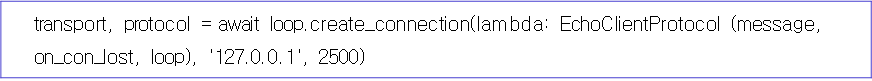

* EchoClientProtocol: 프로토콜 클래스  
* transport: 연결 소켓  
* protocol: 프로토콜 클래스 객체  

**프로그램 구성**  
```
 async def main():
   # create_coonection()을 이용하여 서버와 연결
   # 퓨처 객체를 생성
   # 프로토콜 클래스에서 퓨처 객체가 완료로 표시되면 소켓 종료
 
 프로토콜 클래스(EchoClientProtocol)
   # 인스턴스 변수 설정
   # 콜백 메서드 정의
   def connection_made(self, transport):
   def data_received(self, data):
   def connection_lost(self, exc):
     # 퓨처 객체 완료 표시
```


In [ ]:
#asyncio_TCP_echo_create_client.py
#loop.create_server()를 이용한 TCP 클라이언트

import asyncio

#이벤트 콜백을 정의하는 protocol 클래스
class EchoClientProtocol(asyncio.Protocol):
    def __init__(self, message, on_con_lost, loop):
        self.message = message
        self.loop = loop
        self.on_con_lost = on_con_lost

    def connection_made(self, transport):
        transport.write(self.message.encode())
        print('Data sent: {!r}'.format(self.message))

    def data_received(self, data):
        print('Data received: {!r}'.format(data.decode()))

    def connection_lost(self, exc):
        print('The server closed the connection')
        #동작 종료 표시
        self.on_con_lost.set_result(True)


async def main():
    # 이벤트 루프를 가져온다
    loop = asyncio.get_running_loop()

    # 퓨처 객체 생성
    on_con_lost = loop.create_future()
    message = 'Hello World!'

    # 서버와 연결
    transport, protocol = await loop.create_connection(
        lambda: EchoClientProtocol(message, on_con_lost, loop),
        '127.0.0.1', 2500)

    # 프로토콜이 연결 종료를 알릴 때까지 대기
    try:
        await on_con_lost
    finally:
        transport.close()


asyncio.run(main())

**[실행 방법]**  
서버 프로그램(asyncio_TCP_echo_create_server.py)에서 라인 26을 제거하고 실행한다. 이 라인을 제거하면 연결이 종료되지 않고 계속 유지된다. 클라이언트(TCP_client.py)를 두 번 동시 실행하여 동시 서비스를 확인해 보자. 또 asyncio_TCP_echo_create_server.py와 asyncio_TCP_echo_create_client.py를 실행해서 결과를 살펴보자.